In [2]:
import cv2
import numpy as np

In [3]:
from IPython.display import display, Image

def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))

In [4]:
def fit_size(img, h, w):
    size = img.shape[:2]
    f = min(h / size[0], w / size[1])
    return cv2.resize(img, (int(size[1] * f), int(size[0] * f)), interpolation=cv2.INTER_AREA)

In [5]:
import glob
files = glob.glob('images/manual_trim/*')
imgs = [cv2.imread(f) for f in files]
imgs = [fit_size(img, 500, 500) for img in imgs]

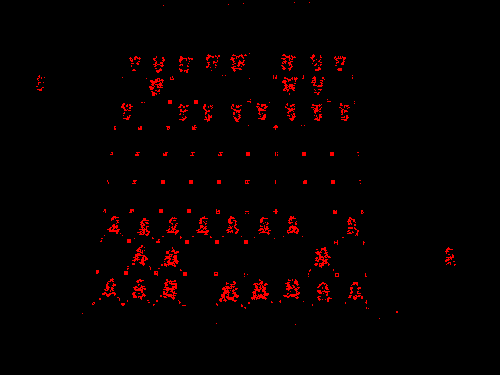

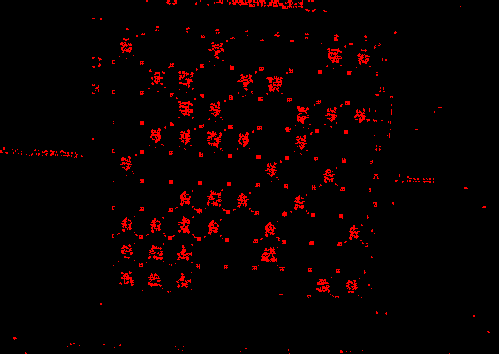

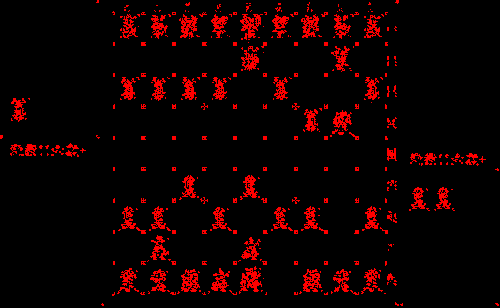

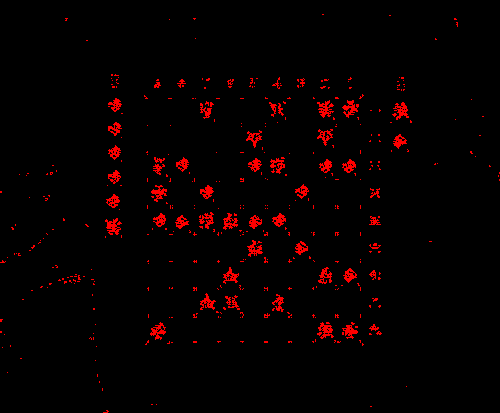

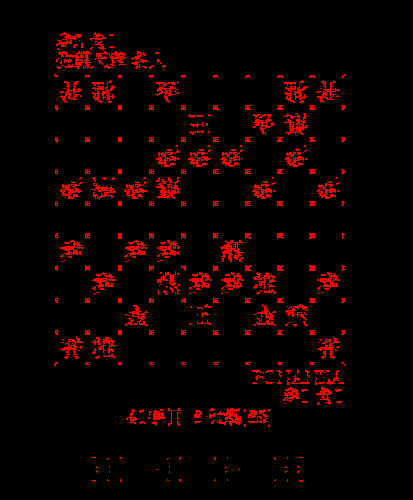

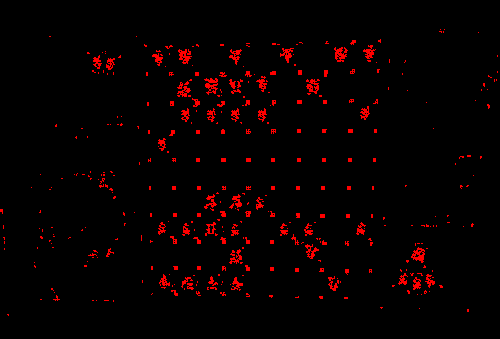

In [6]:
def corner(img, show=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    dot_img = np.copy(img)
    dot_img[corners > 0.01 * corners.max()] = [0, 0, 255]

    blank = np.zeros(img.shape, np.uint8)
    blank[corners > 0.01 * corners.max()] = [0, 0, 255]
    if show:
        display_cv_image(blank)
    return corners

for img in imgs:
    corner(img)

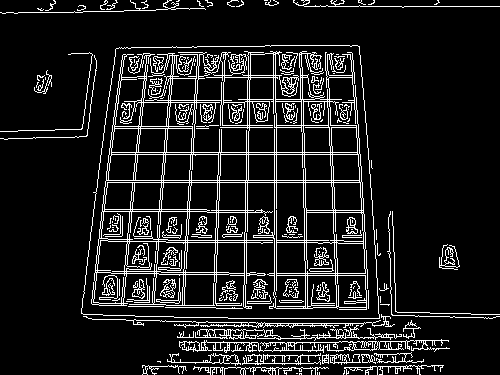

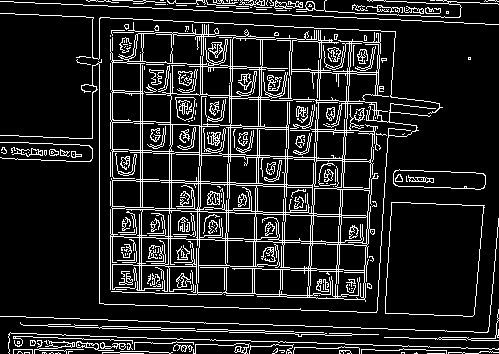

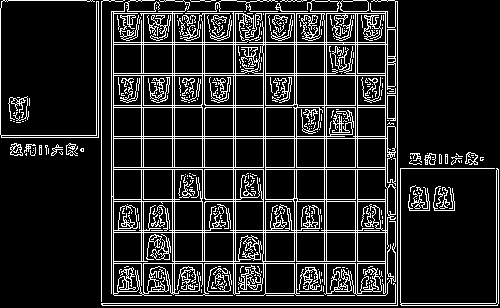

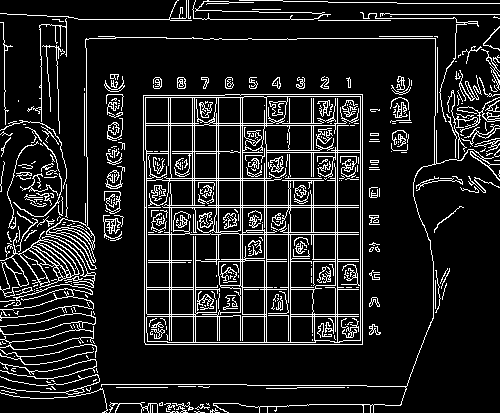

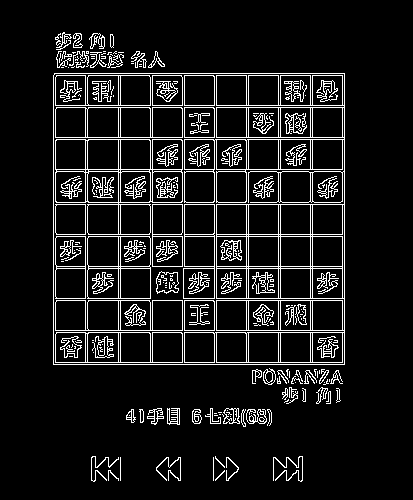

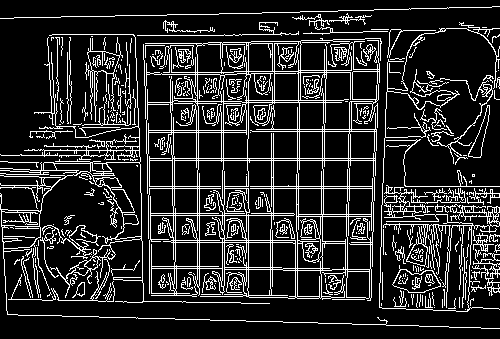

In [7]:
def edge(img, show=True):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    if show:
        display_cv_image(edges)
    return edges

for img in imgs:
    edge(img)

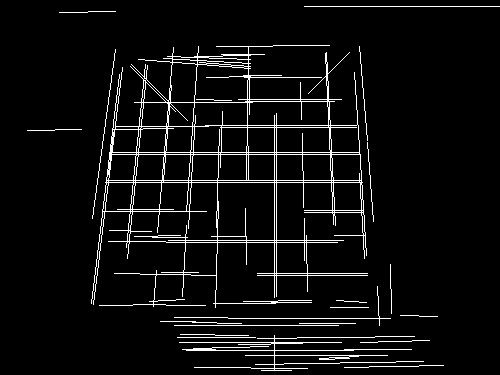

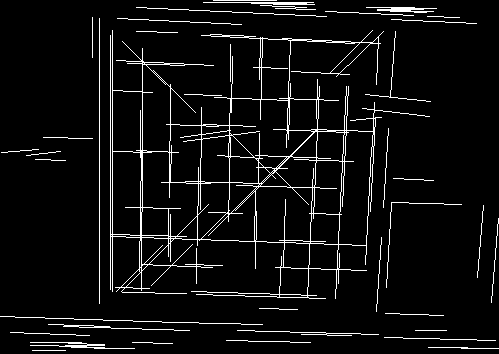

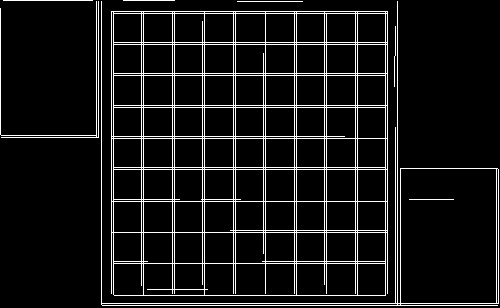

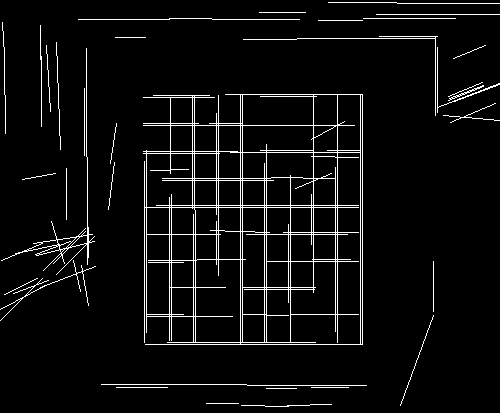

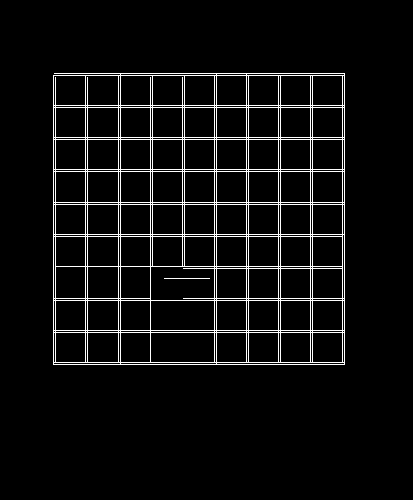

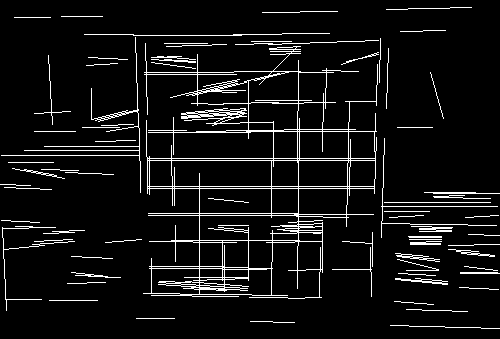

In [15]:
def line(img, show=True, threshold=80, minLineLength=30, maxLineGap=5):
    edges = edge(img, False)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold, 200, minLineLength, maxLineGap)
    if show:
        blank = np.zeros(img.shape, np.uint8)
        for x1, y1, x2, y2 in lines[:, 0]:
            cv2.line(blank, (x1, y1), (x2, y2), (255, 255, 255), 1)
        display_cv_image(blank)
    return lines

for img in imgs:
    line(img)

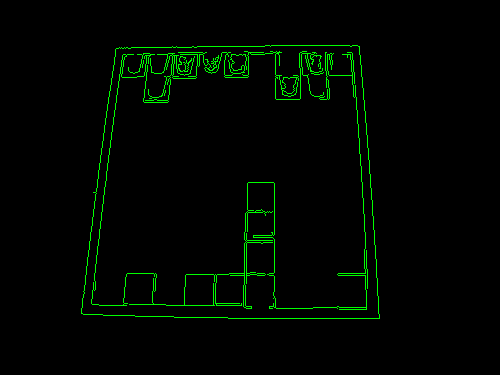

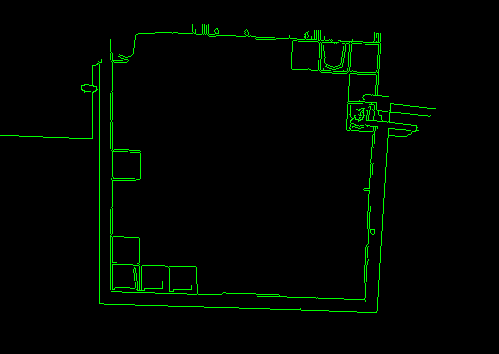

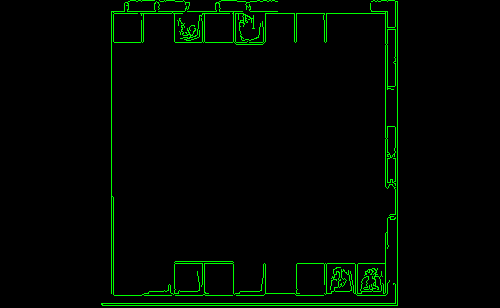

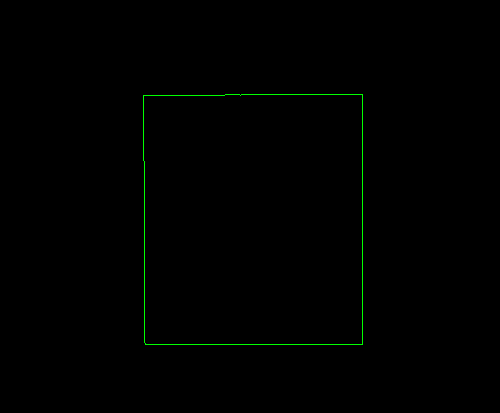

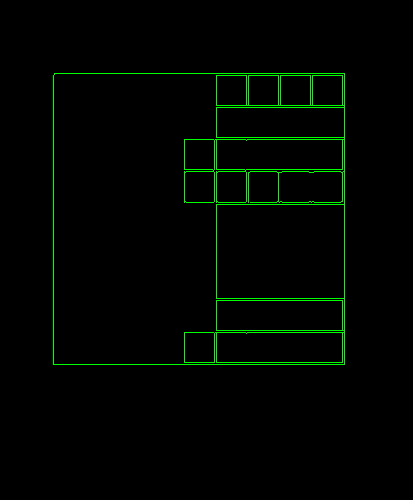

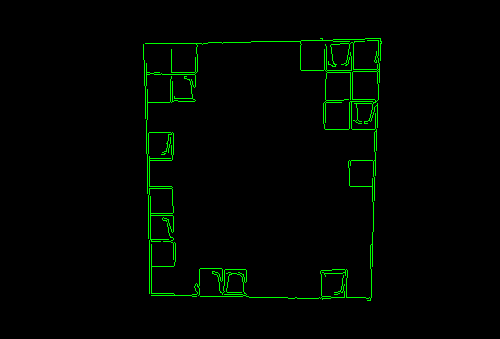

In [9]:
def contours(img, show=True):
    edges = edge(img, False)
    contours = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
    blank = np.zeros(img.shape, np.uint8)
    min_area = img.shape[0] * img.shape[1] * 0.2 # 画像の何割占めるか
    large_contours = [c for c in contours if cv2.contourArea(c) > min_area]
    cv2.drawContours(blank, large_contours, -1, (0,255,0), 1)
    if show:
        display_cv_image(blank)
    return large_contours

for img in imgs:
    contours(img)

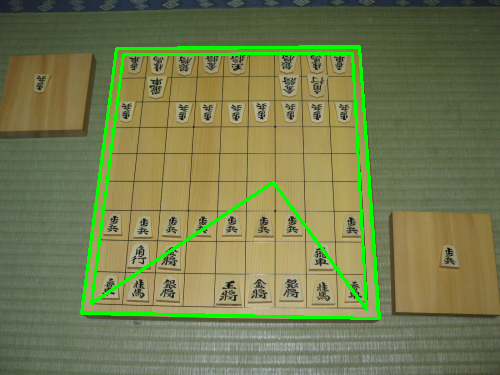

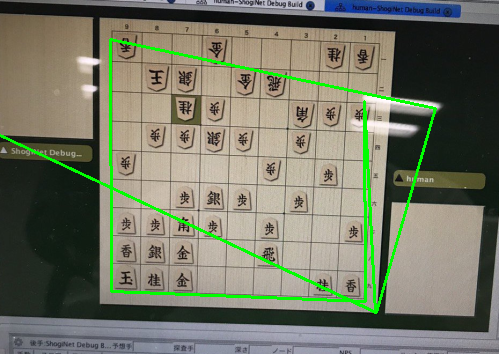

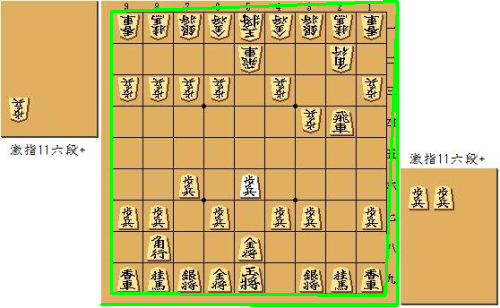

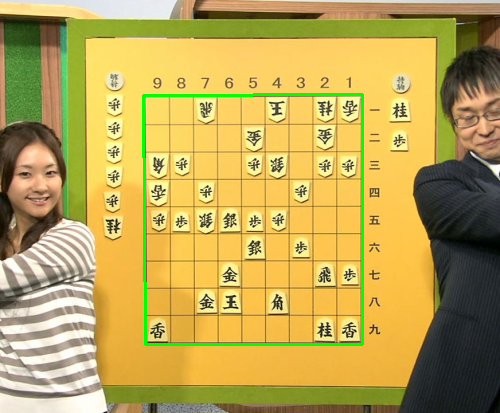

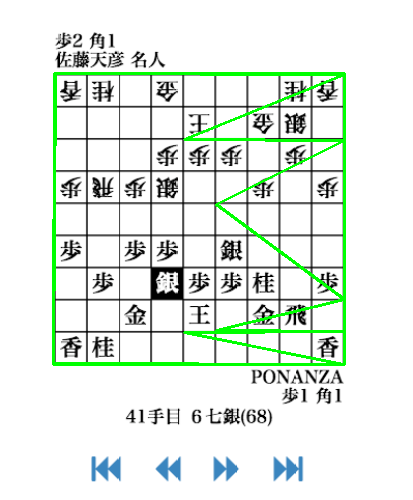

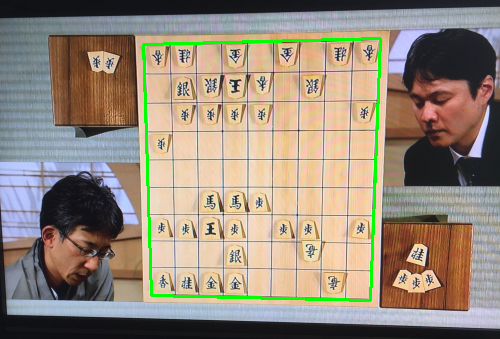

In [10]:
def poly(img, show=True):
    blank = np.copy(img)
    for cnt in contours(img, False):
        arclen = cv2.arcLength(cnt, True)
        poly = cv2.approxPolyDP(cnt, 0.02*arclen, True)
        cv2.drawContours(blank, [poly], -1, (0,255,0), 2)
    if show:
        display_cv_image(blank)

for img in imgs:
    poly(img)

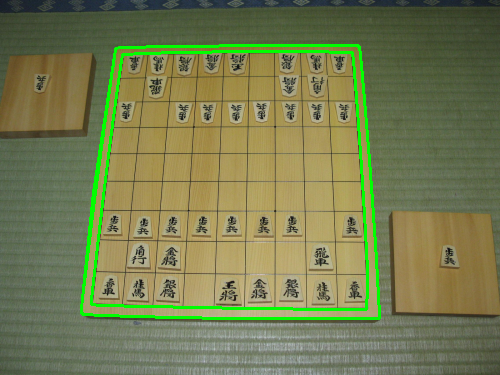

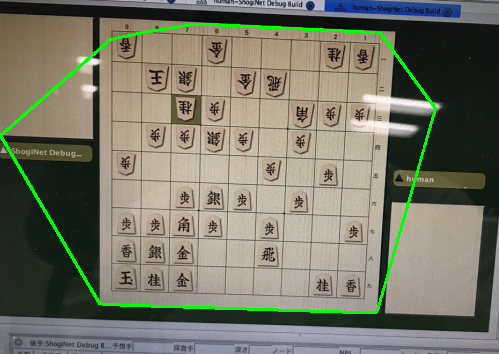

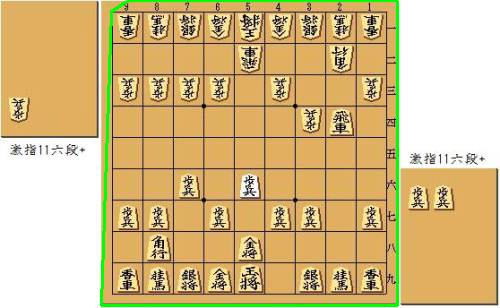

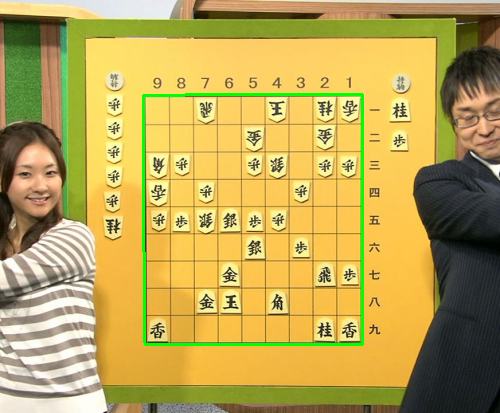

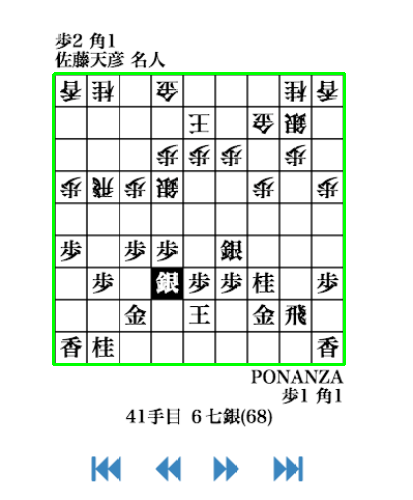

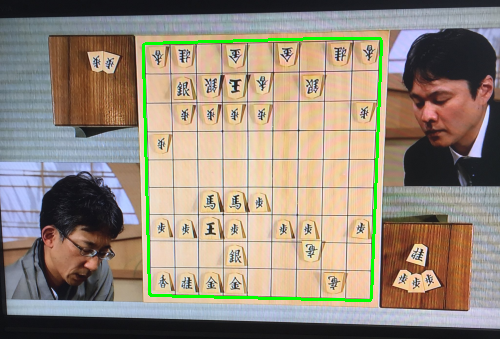

In [11]:
def convex(img, show=True):
    blank = np.copy(img)
    convexes = []
    for cnt in contours(img, False):
        convex = cv2.convexHull(cnt)
        cv2.drawContours(blank, [convex], -1, (0,255,0), 2)
        convexes.append(convex)
    if show:
        display_cv_image(blank)
    return convexes

for img in imgs:
    convex(img)

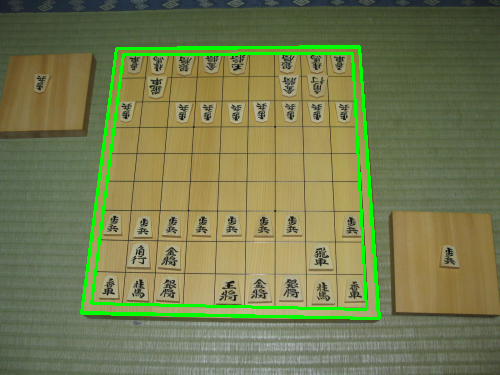

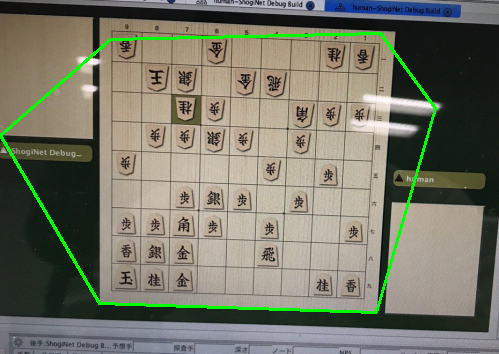

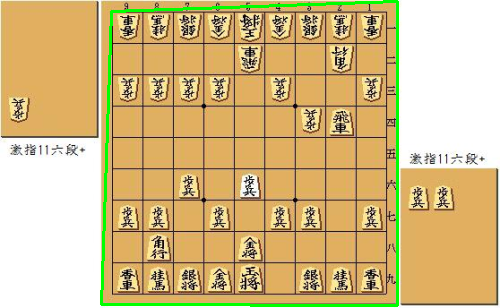

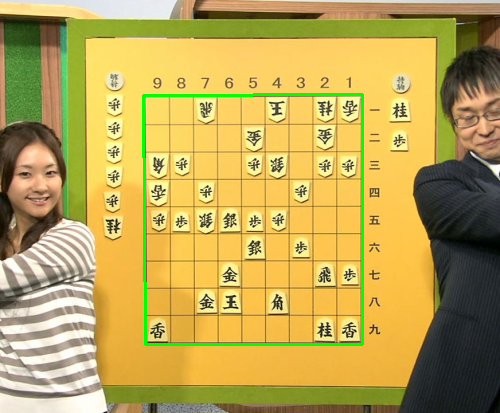

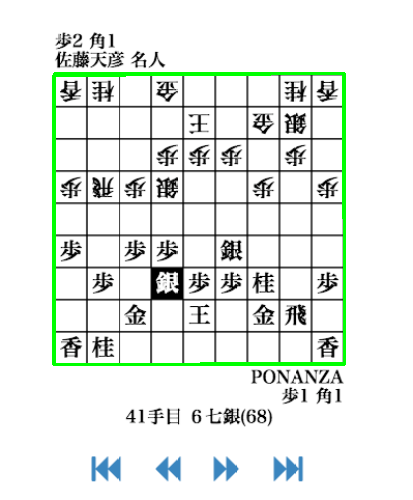

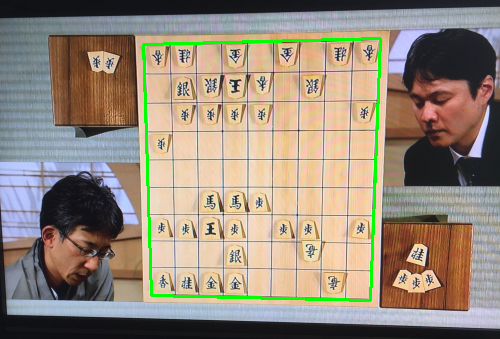

In [127]:
def convex_poly(img, show=True):
    cnts = convex(img, False)
    blank = np.copy(img)
    polies = []
    for cnt in cnts:
        arclen = cv2.arcLength(cnt, True)
        poly = cv2.approxPolyDP(cnt, 0.02*arclen, True)
        cv2.drawContours(blank, [poly], -1, (0,255,0), 2)
        polies.append(poly)
    if show:
        display_cv_image(blank)
    return polies

for img in imgs:
    convex_poly(img)

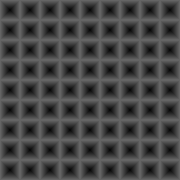

In [192]:
def gen_score_mat():
    half_a = np.fromfunction(lambda i, j: (10 - i) * 10, (10, 20), dtype=np.uint8)
    half_b = np.rot90(half_a, 2)
    cell_a = np.r_[half_a, half_b]
    cell_b = np.rot90(cell_a)
    cell = np.maximum(cell_a, cell_b)
    return np.tile(cell, (9, 9))

display_cv_image(gen_score_mat())

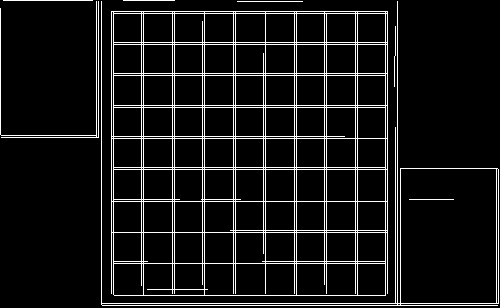

-9.42414676172
-9.44383266211
[ 397.22049254  305.26829159  101.19726234  304.45195595  111.12958928
   11.22872675  397.05353676    0.68617153]


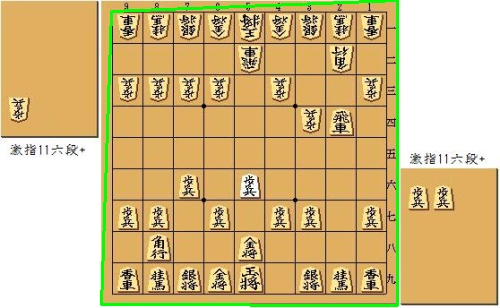

In [191]:
img = imgs[2]

lines = line(img, False)
line_mat = np.zeros(img.shape, np.uint8)
for x1, y1, x2, y2 in lines[:, 0]:
    cv2.line(line_mat, (x1, y1), (x2, y2), 255, 1)
line_mat = line_mat[:, :, 0]
display_cv_image(line_mat)

score_mat = gen_score_mat()
score_mat = score_mat / 100.0
polies = convex_poly(img, False)
poly = polies[0]

def get_score(x):
    img_pnts = np.float32([[x[0], x[1]], [x[2], x[3]], [x[4], x[5]], [x[6], x[7]]])
    score_size = score_mat.shape[0]
    score_pnts = np.float32([[0, 0], [0, score_size], [score_size, score_size], [score_size, 0]])

    transform = cv2.getPerspectiveTransform(score_pnts, img_pnts)
    warped = cv2.warpPerspective(score_mat, transform, (img.shape[1], img.shape[0]))
    # display_cv_image(warped)

    res = line_mat * warped
    return -res.sum() / 500 / 500

# img_pnts = np.float32([p[0] for p in poly])
x0 = poly.flatten()
print(get_score(x0))

from scipy.optimize import basinhopping
ret = basinhopping(get_score, x0, minimizer_kwargs={"method": "BFGS"}, niter=1000, stepsize=0.5)

print(ret.fun)
print(ret.x)

x = ret.x
cntr = np.int32([[x[0],  x[1]], [x[2], x[3]], [x[4], x[5]], [x[6], x[7]]])

blank = np.copy(img)
cv2.drawContours(blank, [cntr], -1, (0,255,0), 2)
display_cv_image(blank)